## Reinforcement Learning Tarea 1 - K Armed Bandits

### Objetivos:
Demostrar entendimiento sobre K-Armed Bandits, implementar varios algoritmos vistos en el curso teórico y comparar su performance en un mismo problema (ambiente).

### A entregar:
- Implementación de agente arbitrario.
- Implementación de agente epsilon-greedy.
- Implementación de agente epsilon-greedy optimista.
- Implementación de agente upper confidence bound.
- Grafique la evolución de las recompensas (reward) a lo largo del tiempo para cada algoritmo, promediado sobre 10 ejecuciones.
- Escriba un reporte sobre sus implementaciones comparando los distintos agentes implementados.

### Instalación y carga de ambiente

`git clone https://github.com/JKCooper2/gym-bandits.git`

`cd gym-bandits`

`pip install .`

In [ ]:
# Para usarlo desde Google Colab
!git clone https://github.com/JKCooper2/gym-bandits.git
!cd gym-bandits
!pip install gym-bandits/

## Descripción del ambiente a usar

Vamos a usar GymBandits, una libreria diseñada para ser utilizada sobre OpenAi Gym (https://gym.openai.com/) pero orientada a Armed Bandits. 

Recordando el teórico, sabemos que un K Armed Bandit representa una maquina tragamonedas con multiples brazos (K) y donde nuestra recompensa depende de cual brazo tiremos.

En este caso particular, `BanditTenArmedGaussian` es el ambiente a utilizar (página 30 del libro de Sutton y Barto), cuenta con 10 brazos (K=10) y por cada interaccion con el ambiente (`step`) nustra recompensa (reward) depende de que brazo elegimos entre los 10 posibles. En este ambiente, todos los brazos tienen una recompensa (que puede ser negativa en algunos casos) y nuestro objetivo es diseñar agentes que maximicen la suma total de recompensas a lo largo de 1000 interacciones con el ambiente (`1000 steps`).

## Definicion del ambiente e imports necesarios

In [3]:
import gym
import random
import gym_bandits
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("BanditTenArmedGaussian-v0")

In [4]:
env.action_space

Discrete(10)

In [5]:
number_steps = 1000

### Implementación de agente arbitrario

In [6]:
def random_agent():
    observation = env.reset()
    rewards = []
    
    for _ in range(number_steps):
        env.render()
        action = env.action_space.sample() # take a random action
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
    
    return np.array(rewards)  

# Example run
example_rewards = random_agent() 

In [7]:
print (f"Accumulated reward: {sum(example_rewards):.2f}")
print (f"Mean reward: {example_rewards.mean():.2f}")

Accumulated reward: -332.51
Mean reward: -0.33


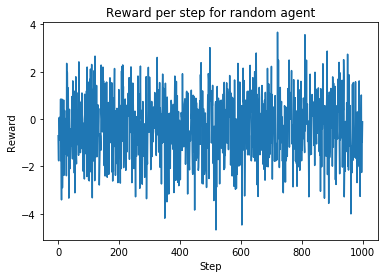

In [8]:
# Example plot
plt.plot(range(number_steps), example_rewards)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Reward per step for random agent")
plt.show()

### Implementación de agente epsilon-greedy

In [9]:
def epsilon_greedy_agent(epsilon):
    observation = env.reset()
    rewards = []
    #Nuevo:
    n_t = np.zeros(10)
    q_a = np.zeros(10)
    #--

    for _ in range(number_steps):      
        rnd = random.random()#Número al azar entre 0 y 1
        exploit = rnd > epsilon
        #explore = rnd <= epsilon
        if exploit:
              action = np.argmax(q_a)
        else:
              action = env.action_space.sample() # take a random action
        
        _, reward, _, _ = env.step(action)
        #alpha = tasa de actualización
        n_t[action]+=1
          
        alpha = 1/n_t[action]
        q_a[action] = q_a[action] + alpha*(reward - q_a[action])

        rewards.append(reward)
    
    return np.array(rewards), n_t, q_a 

# Example run
epsilon_greedy_rewards, n_t, q_a= epsilon_greedy_agent(0.3) 
print(n_t)
print(q_a)
print (f"Accumulated reward: {sum(epsilon_greedy_rewards):.2f}")
print (f"Mean reward: {epsilon_greedy_rewards.mean():.2f}")

[ 26.  39.  30.  28.  25.  64.  24. 696.  38.  30.]
[-1.68599005  0.22865362 -1.14066171 -0.41125797 -0.76629434  0.60346346
  0.42248992  0.84270574 -1.54950259 -0.9826273 ]
Accumulated reward: 447.11
Mean reward: 0.45


### Implementación de agente epsilon-greedy optimista

In [11]:
def optimistic_epsilon_greedy_agent(epsilon, initial_q_a = 10):
    observation = env.reset()
    rewards = []
    #Nuevo:
    n_t = np.zeros(10)
    q_a = np.ones(10)*10
    #--

    for _ in range(number_steps):       
        rnd = random.random()#Número al azar entre 0 y 1
        exploit = rnd > epsilon
        #explore = rnd <= epsilon
        if exploit:
              action = np.argmax(q_a)
        else:
              action = env.action_space.sample() # take a random action
        
        _, reward, _, _ = env.step(action)
        #alpha = tasa de actualización
        n_t[action]+=1
          
        alpha = 1/n_t[action]
        q_a[action] = q_a[action] + alpha*(reward - q_a[action])

        rewards.append(reward)
    
    return np.array(rewards), n_t, q_a 

# Example run
optimistic_epsilon_greedy_rewards, n_t, q_a= epsilon_greedy_agent(0.3) 
print(n_t)
print(q_a)
print (f"Accumulated reward: {sum(optimistic_epsilon_greedy_rewards):.2f}")
print (f"Mean reward: {optimistic_epsilon_greedy_rewards.mean():.2f}")

[ 30.  46.  31.  37.  22.  34.  38. 701.  34.  27.]
[-1.32820205  0.59672988 -0.78783927  0.16196208 -0.57834663  0.34952333
  0.72665585  0.89480094 -2.00270674 -0.89708336]
Accumulated reward: 530.89
Mean reward: 0.53


### Implementación de agente upper confidence bound

In [26]:
def UCB_agent(c):
    observation = env.reset()
    rewards = []
    #Nuevo:
    n_t = np.ones(10)
    q_a = np.zeros(10)   
    #--

    for t in range(1,number_steps+1):
        #Selección de acción de acuerdo a UCB
        action = np.argmax(q_a+ c*np.sqrt(np.log(t)/n_t))
        
        _, reward, _, _ = env.step(action)        
        #alpha = tasa de actualización
        n_t[action]+=1          
        alpha = 1/n_t[action]
        q_a[action] = q_a[action] + alpha*(reward - q_a[action])

        rewards.append(reward)
    
    return np.array(rewards), n_t, q_a 

# Example run
optimistic_epsilon_greedy_rewards, n_t, q_a= epsilon_greedy_agent(0.3) 
print(n_t)
print(q_a)
print (f"Accumulated reward: {sum(optimistic_epsilon_greedy_rewards):.2f}")
print (f"Mean reward: {optimistic_epsilon_greedy_rewards.mean():.2f}")

[ 29.  34.  37.  30.  29.  34.  31. 714.  30.  32.]
[-1.79466209  0.00341737 -0.97763026  0.3444074  -0.43617963  0.62722558
  0.30729282  0.8963766  -1.59207173 -0.95391871]
Accumulated reward: 502.16
Mean reward: 0.50


### Reporte

In [27]:
def calculate_means(n_steps, agent, param):
    excecutions = []
    for i in range(n_steps):
        excecution = agent(param)[0]
        excecutions.append(excecution)
    means = np.mean(excecutions, axis = 0)
    return means

In [44]:
parameters_eps_greedy = [0, 0.1, 0.01]

#Para epsilon greedy optimista con tasa de actualización no fija con que Q0 esté sobre la media basta (default 10 = OK)
parameters_eps_greedy_opt = [0, 0.1, 0.01]


parameters_ucb = [0.25, 0.5, 1, 2, 4]

n_steps = 1000
eps_greedy_results = list(map(lambda x: (x,calculate_means(n_steps, epsilon_greedy_agent ,x)), parameters_eps_greedy))

eps_greedy_opt_results = list(map(lambda x: (x,calculate_means(n_steps, optimistic_epsilon_greedy_agent ,x)), parameters_eps_greedy_opt))

ucb_results = list(map(lambda x: (x,calculate_means(n_steps, UCB_agent,x)), parameters_ucb))

In [36]:
def plot_results(results, param_name, plot_title):
    plt.figure(figsize=(10,5))
    for param, means in results:
        plt.plot(range(number_steps), means, label=param_name+' = '+str(param))
    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.title(plot_title)
    plt.legend()
    plt.show()

#### Epsilon Greedy:

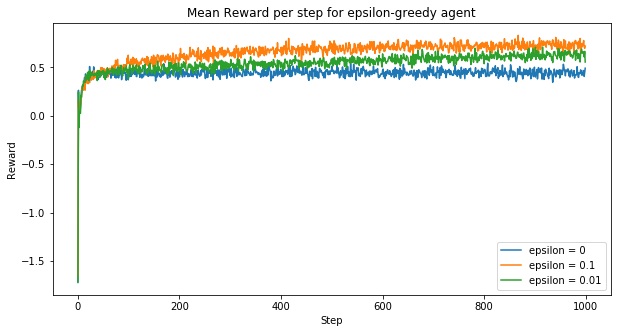

In [48]:
plot_results(eps_greedy_results, "epsilon","Mean Reward per step for epsilon-greedy agent")

#### Comentarios:
Se puede observar que a medida que los steps avanzan, y los valores de Q van quedando mejor estimados, el agente que optimiza la reward es el que juega más frecuentemente de manera greedy (epsilon = 0.1)

#### Epsilon Greedy Optimista:

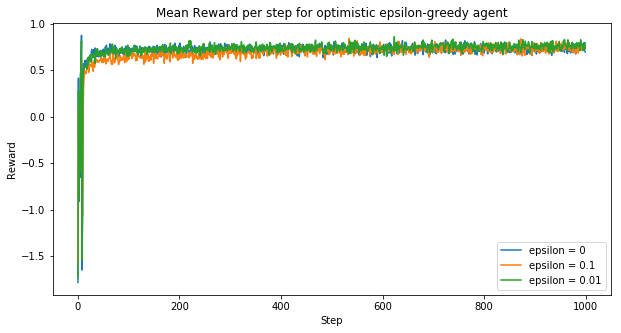

In [49]:
plot_results(eps_greedy_opt_results, "epsilon","Mean Reward per step for optimistic epsilon-greedy agent")

#### Comentarios:
Las gráficas solapadas dificultan el análisis, posible solución: cambiar de escala. Se observan los picos iniciales asociados a la exploración "forzada" que epsilon greedy optimista tiene. Todos los parámetros tienen convergencia más rapida que epsilon greedy sin embargo se estancan en valores similares, esto es por la misma razón que los agentes epsilon-greedy que tienen un porcentaje fijo de exploración.

#### UCB

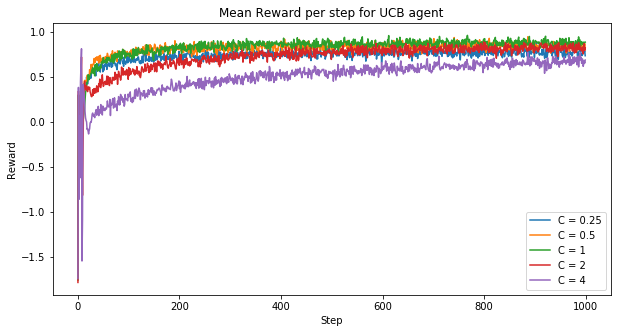

In [50]:
plot_results(ucb_results, "C","Mean Reward per step for UCB agent")

#### Comentarios:
Se ve que no hay una relación lineal entre C y la media de los rewards.
En este caso se puede ver consistencia con lo visto en el teórico, donde el valor de C = 1 es el que optimiza las rewards. 

#### A continuación compararemos los que mejor resultado dan en una misma gráfica

In [54]:
eps_greedy_results_means = list(map(lambda x: (x[0], x[1],np.mean(x[1])), eps_greedy_results))
eps_greedy_opt_results_means = list(map(lambda x: (x[0], x[1],np.mean(x[1])), eps_greedy_opt_results))
ucb_results_means  = list(map(lambda x: (x[0], x[1],np.mean(x[1])), ucb_results))

In [61]:
best_eps_greedy = max(eps_greedy_results_means,key=lambda item:item[2])
best_eps_greedy_opt = max(eps_greedy_opt_results_means,key=lambda item:item[2])
best_ucb = max(ucb_results_means,key=lambda item:item[2])

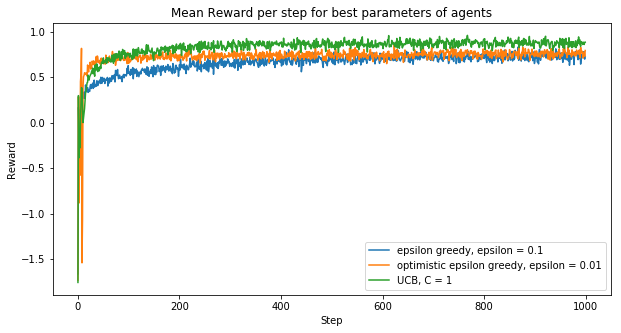

In [62]:
plt.figure(figsize=(10,5))    
plt.plot(range(number_steps), best_eps_greedy[1], label='epsilon greedy, epsilon = '+str(best_eps_greedy[0]))
plt.plot(range(number_steps), best_eps_greedy_opt[1], label='optimistic epsilon greedy, epsilon = '+str(best_eps_greedy_opt[0]))
plt.plot(range(number_steps), best_ucb[1], label='UCB, C = '+str(best_ucb[0]))
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Mean Reward per step for best parameters of agents")
plt.legend()
plt.show()

#### Comentarios:
Se confirma lo comentado anteriormente, epsilon greedy optimista es mejor que epsilon greedy al inicio y luego presentan convergencia relacionada a su parametro de exploración.
UCB Presenta mejor balance, a pesar de demorar más en converger logra a la larga superar a los otros dos agentes.